# Digits to Calculator

Based on https://towardsdatascience.com/building-a-handwritten-multi-digit-calculator-f03cf5028052

### Pre processing

In [5]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
#Labels
y = df["label"]

#Variables
X = df.drop(labels = ["label"], axis = 1)

#Delete to memory use
del df

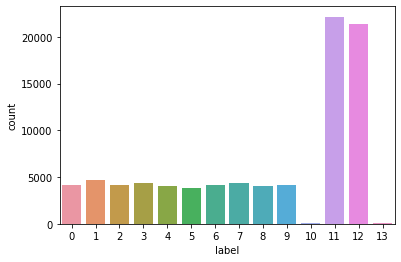

In [4]:
#Pre Analising
g = sns.countplot(y)

In [5]:
#Normalization
X = X / 255.0

#Reshape Dataset
X = X.values.reshape(-1,28,28,1)

#Enconding
y = to_categorical(y, num_classes = 14)

#Dividing in train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2,stratify = y)

### Neural Network

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow import keras

In [7]:
#Creating model
model = Sequential()


#Layer: 1
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Layer: 2
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))


#fully connected layer and output
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(14, activation = "softmax"))



#Optmizer
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay=0.0 )

#Model Compile
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])


#Learining Rate
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_loss", patience = 3, verbose = 1,
                                            factor = 0.5, min_lr = 0.0001)



C:\Users\mateu\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
#Prepare the image
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#Training and prepare
datagen.fit(X_train)

In [9]:
#Training
epochs = 15
batch_size = 90


history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, #An epoch is an iteration over the entire x and y data provided
                              validation_data = (X_val,y_val), #Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                              verbose = 1, #output
                              steps_per_epoch=X_train.shape[0] // batch_size,  # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
                              callbacks=[learning_rate_reduction]                            
                              )

C:\Users\mateu\anaconda3\lib\site-packages\keras\engine\training.py:1914: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
761/761 [==============================] - 575s 719ms/step - loss: 0.6396 - accuracy: 0.8086 - val_loss: 0.0411 - val_accuracy: 0.9868
Epoch 2/15
761/761 [==============================] - 549s 722ms/step - loss: 0.0898 - accuracy: 0.9734 - val_loss: 0.0389 - val_accuracy: 0.9882
Epoch 3/15
761/761 [==============================] - 572s 751ms/step - loss: 0.0702 - accuracy: 0.9793 - val_loss: 0.0276 - val_accuracy: 0.9921
Epoch 4/15
761/761 [==============================] - 554s 728ms/step - loss: 0.0587 - accuracy: 0.9833 - val_loss: 0.0357 - val_accuracy: 0.9896
Epoch 5/15
761/761 [==============================] - 579s 761ms/step - loss: 0.0545 - accuracy: 0.9837 - val_loss: 0.0346 - val_accuracy: 0.9915
Epoch 6/15
761/761 [==============================] - 554s 728ms/step - loss: 0.0564 - accuracy: 0.9850 - val_loss: 0.0263 - val_accuracy: 0.9924
Epoch 7/15
761/761 [==============================] - 552s 726ms/step - loss: 0.0546 - accuracy: 0.9844 - val_loss: 0.0324 -

In [10]:
model.save('model.h5')

In [2]:
from PIL import Image
from itertools import groupby


def predict(img="output.png"):
    #loading image
    image = Image.open(img).convert("L")
    
    
    #Pre processing
    w = image.size[0]
    h = image.size[1]
    r = w / h # aspect ratio
    new_w = int(r * 28)
    new_h = 28
    new_image = image.resize((new_w, new_h))

    #converting to a numpy array
    new_image_arr = np.array(new_image)

    #inverting the image to make background = 0
    new_inv_image_arr = 255 - new_image_arr

    #rescaling the image
    final_image_arr = new_inv_image_arr / 255.0

    #splitting image array into individual element arrays using non zero columns
    m = final_image_arr.any(0)
    out = [final_image_arr[:,[*g]] for k, g in groupby(np.arange(len(m)), lambda x: m[x] != 0) if k]


    '''
    iterating through the element arrays to resize them to match input 
    criteria of the model = [mini_batch_size, height, width, channels]
    '''
    num_of_elements = len(out)
    elements_list = []
    for x in range(0, num_of_elements):
        img = out[x]

        #adding 0 value columns as fillers
        width = img.shape[1]
        filler = (final_image_arr.shape[0] - width) / 2

        if filler.is_integer() == False:    #odd number of filler columns
            filler_l = int(filler)
            filler_r = int(filler) + 1
        else:                               #even number of filler columns
            filler_l = int(filler)
            filler_r = int(filler)

        arr_l = np.zeros((final_image_arr.shape[0], filler_l)) #left fillers
        arr_r = np.zeros((final_image_arr.shape[0], filler_r)) #right fillers

        #concatinating the left and right fillers
        help_ = np.concatenate((arr_l, img), axis= 1)
        element_arr = np.concatenate((help_, arr_r), axis= 1)

        element_arr.resize(28, 28, 1) #resize array 2d to 3d
        #storing all elements in a list
        elements_list.append(element_arr)
    elements_array = np.array(elements_list)
    
    #reshaping to fit model input criteria'
    elements_array = elements_array.reshape(-1, 28, 28, 1)
    
    #predicting using the created model'
    model = keras.models.load_model("model.h5")
    elements_pred =  model.predict(elements_array)
    elements_pred = np.argmax(elements_pred, axis = 1)
    return elements_pred

In [8]:
elements_pred = predict("output.png")

In [9]:
def math_expression_generator(arr):
    
    op = {
              10,   # = "/"
              11,   # = "+"
              12,   # = "-"
              13    # = "*"
                  }   
    
    m_exp = []
    temp = []
        
    #creating a list separating all elements
    for item in arr:
        if item not in op:
            temp.append(item)
        else:
            m_exp.append(temp)
            m_exp.append(item)
            temp = []
    if temp:
        m_exp.append(temp)
        
    #converting the elements to numbers and operators
    i = 0
    num = 0
    for item in m_exp:
        if type(item) == list:
            if not item:
                m_exp[i] = ""
                i = i + 1
            else:
                num_len = len(item)
                for digit in item:
                    num_len = num_len - 1
                    num = num + ((10 ** num_len) * digit)
                m_exp[i] = str(num)
                num = 0
                i = i + 1
        else:
            m_exp[i] = str(item)
            m_exp[i] = m_exp[i].replace("10","/")
            m_exp[i] = m_exp[i].replace("11","+")
            m_exp[i] = m_exp[i].replace("12","-")
            m_exp[i] = m_exp[i].replace("13","*")
            
            i = i + 1
    
    
    #joining the list of strings to create the mathematical expression'
    separator = ' '
    m_exp_str = separator.join(m_exp)
    
    return (m_exp_str)

#creating the mathematical expression'
m_exp_str = math_expression_generator(elements_pred)

#calculating the mathematical expression using eval()'
while True:
    try:
        answer = eval(m_exp_str)    #evaluating the answer
        answer = round(answer, 2)
        equation  = m_exp_str + " = " + str(answer)
        print(equation)   #printing the equation
        break

    except SyntaxError:
        print("Invalid predicted expression!!")
        print("Following is the predicted expression:")
        print(m_exp_str)
        break

Invalid predicted expression!!
Following is the predicted expression:
 * 1
